<a href="https://colab.research.google.com/github/marceloc78/MDI/blob/master/mdi_trabajo_final_pruebas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline 
import matplotlib.pylab as plt 
import numpy as np 
from scipy import sparse 
from sklearn.datasets import make_classification, make_blobs, load_boston, fetch_california_housing 
from sklearn.decomposition import PCA 
from sklearn.model_selection import ShuffleSplit, train_test_split,learning_curve,GridSearchCV
from sklearn import metrics 
from sklearn.linear_model import LinearRegression 
from sklearn.ensemble import GradientBoostingRegressor 
from sklearn.preprocessing import PowerTransformer
from pprint import pprint 
import pandas as pd 
import urllib 
import requests 
import zipfile 
import seaborn

from sklearn.metrics import mean_squared_error as MSE
SEED = 1

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
data=pd.read_csv('https://raw.githubusercontent.com/marceloc78/MDI/master/DIB_dataset.tsv',sep="\t")

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10956 entries, 0 to 10955
Columns: 192 entries, locality_code to n_days_since_1st_death
dtypes: float64(180), int64(6), object(6)
memory usage: 16.0+ MB


In [4]:
data.columns

Index(['locality_code', 'locality_name', 'date', 'new_cases', 'new_deaths',
       'acc_cases', 'acc_deaths',
       'index_of_industrial_production:_total_industry_mining;_manufacturing;_electricity_gas_and_water_(index_base:_2005=100)_2014',
       'index_of_industrial_production:_mining_(index_base:_2005=100)_2014',
       'index_of_industrial_production:_manufacturing_(index_base:_2005=100)_2014',
       ...
       'retail_recreation', 'grocery_pharmacy', 'parks', 'transit_stations',
       'workplaces', 'residential', 'first_case_date', 'n_days_since_1st_case',
       'first_death_date', 'n_days_since_1st_death'],
      dtype='object', length=192)

In [8]:
cols=['locality_name','new_cases', 'retail_recreation','grocery_pharmacy','parks',\
       'transit_stations','workplaces','residential', 'urban_population_(percent)_2018', \
       'population_density_2019', 'gdp_per_capita_(us_dollars)_2017','infant_mortality_for_both_sexes_(per_1000_live_births)_2015', \
       'maternal_mortality_ratio_(deaths_per_100000_livebirths)_2015','life_expectancy_at_birth_for_both_sexes_(years)_2015', \
       'unemployment_rate_total_2019']

In [9]:
# filtramos columnas que consideramos innecesarias
df=data[cols]

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10956 entries, 0 to 10955
Data columns (total 15 columns):
 #   Column                                                        Non-Null Count  Dtype  
---  ------                                                        --------------  -----  
 0   locality_name                                                 10956 non-null  object 
 1   new_cases                                                     10956 non-null  int64  
 2   retail_recreation                                             10888 non-null  float64
 3   grocery_pharmacy                                              10851 non-null  float64
 4   parks                                                         10809 non-null  float64
 5   transit_stations                                              10867 non-null  float64
 6   workplaces                                                    10927 non-null  float64
 7   residential                                                   10618

In [11]:
# Actualizamos informacion de Bolivia
df.loc[df['locality_name']=='Bolivia','unemployment_rate_total_2019']=4.83
df.loc[df['locality_name']=='Bolivia','life_expectancy_at_birth_for_both_sexes_(years)_2015']=70
df.loc[df['locality_name']=='Bolivia','maternal_mortality_ratio_(deaths_per_100000_livebirths)_2015']=168
df.loc[df['locality_name']=='Bolivia','infant_mortality_for_both_sexes_(per_1000_live_births)_2015']=24.9
df.loc[df['locality_name']=='Bolivia','gdp_per_capita_(us_dollars)_2017']=3351
df.loc[df['locality_name']=='Bolivia','population_density_2019']=10.48
df.loc[df['locality_name']=='Bolivia','urban_population_(percent)_2018']=69.43

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [12]:
# Verificamos que no falte información para Bolivia
df.loc[df['locality_name']=='Bolivia'].isnull().sum()

locality_name                                                   0
new_cases                                                       0
retail_recreation                                               0
grocery_pharmacy                                                0
parks                                                           0
transit_stations                                                0
workplaces                                                      0
residential                                                     0
urban_population_(percent)_2018                                 0
population_density_2019                                         0
gdp_per_capita_(us_dollars)_2017                                0
infant_mortality_for_both_sexes_(per_1000_live_births)_2015     0
maternal_mortality_ratio_(deaths_per_100000_livebirths)_2015    0
life_expectancy_at_birth_for_both_sexes_(years)_2015            0
unemployment_rate_total_2019                                    0
dtype: int

In [18]:
df.describe()

,new_cases,retail_recreation,grocery_pharmacy,parks,transit_stations,workplaces,residential,urban_population_(percent)_2018,population_density_2019,gdp_per_capita_(us_dollars)_2017,infant_mortality_for_both_sexes_(per_1000_live_births)_2015,maternal_mortality_ratio_(deaths_per_100000_livebirths)_2015,life_expectancy_at_birth_for_both_sexes_(years)_2015,unemployment_rate_total_2019
count,10080.000000,10080.000000,10080.000000,10080.000000,10080.000000,10080.000000,10080.000000,10080.000000,10080.000000,10080.000000,10080.000000,10080.000000,10080.000000,10080.000000
mean,328.430159,-33.577976,-16.936111,-17.172917,-35.014980,-25.731944,12.785218,63.431497,239.342224,16790.125893,20.809099,113.487410,72.612145,6.823422
std,1968.638523,31.036876,23.670420,32.814232,30.778555,27.882604,11.877554,22.295758,784.087881,20412.520205,20.323823,161.917285,7.604141,5.196283
min,0.000000,-97.000000,-98.000000,-95.000000,-100.000000,-92.000000,-6.000000,13.200000,2.076000,378.000000,2.065000,2.613100,51.950000,0.100000
25%,0.000000,-62.000000,-32.000000,-41.000000,-62.000000,-50.000000,1.000000,47.200000,33.450700,2342.000000,4.647000,9.697800,68.468000,3.600000
50%,4.000000,-32.000000,-11.000000,-13.000000,-37.000000,-23.000000,12.000000,66.400000,92.374400,7596.000000,12.959000,31.981800,74.251000,5.300000
75%,70.000000,-2.000000,1.000000,2.000000,-3.000000,1.000000,22.000000,82.200000,220.652400,23296.000000,32.943000,149.772200,78.941000,8.500000
max,48529.000000,37.000000,76.000000,188.000000,31.000000,43.000000,55.000000,100.000000,8291.910000,106806.000000,78.465000,813.977400,83.321000,27.600000


In [14]:
# Eliminamos todas las filas con datos nulos
df=df.dropna()

In [16]:
## eliminamos los casos nuevos < 0
df = df[(df[['new_cases']] >= 0).all(axis=1)]

In [17]:
#cambiamos el tipo de columna a categórica
df['locality_name']=df['locality_name'].astype('category')

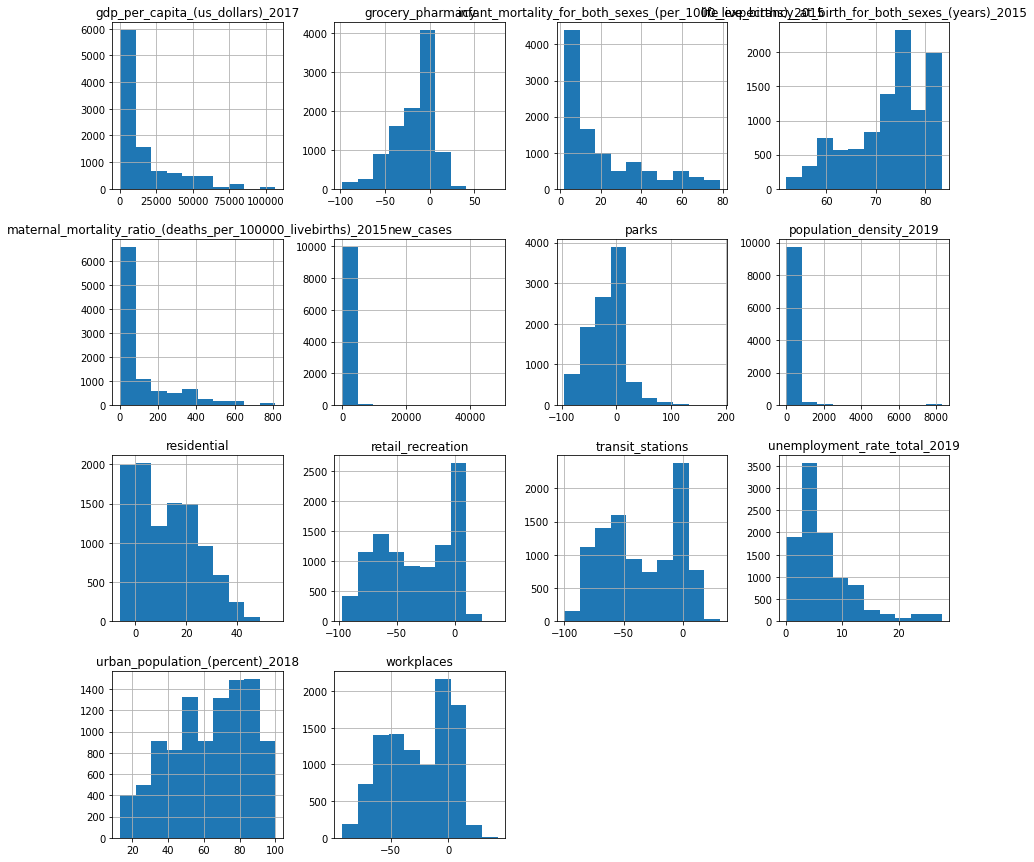

In [19]:
# Graficamos histogramas para ver la distribución de los datos
df.hist(figsize=(15,15))
plt.show()

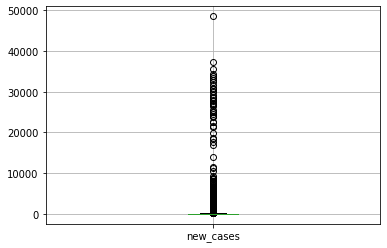

In [20]:
# Verificamos que la columna nuevos casos tiene outliers demasiados alejados del resto
df[['new_cases']].boxplot()
plt.show()

In [21]:
#quitamos todas las filas de USA para disminuir los outliers
df=df[df['locality_name']!='United States']

In [22]:
# transformamos 3 variebles a logaritmicas para darles un poco de normalidad

log_gdp = PowerTransformer()
log_gdp.fit(df[['gdp_per_capita_(us_dollars)_2017']])
df['log_gdp'] = log_gdp.transform(df[['gdp_per_capita_(us_dollars)_2017']])

log_pop_den_2019 = PowerTransformer()
log_pop_den_2019.fit(df[['population_density_2019']])
df['log_pop_den_2019'] = log_pop_den_2019.transform(df[['population_density_2019']])

log_mat_mor_2019 = PowerTransformer()
log_mat_mor_2019.fit(df[['maternal_mortality_ratio_(deaths_per_100000_livebirths)_2015']])
df['log_mat_mor_2019'] = log_mat_mor_2019.transform(df[['maternal_mortality_ratio_(deaths_per_100000_livebirths)_2015']])

In [23]:
# tranformamos la variable location_name a dummies para meterla en el análisis

df2 = pd.get_dummies(df, columns=['locality_name'], prefix='C')

In [26]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9997 entries, 0 to 10955
Columns: 139 entries, new_cases to C_Zimbabwe
dtypes: float64(16), int64(1), uint8(122)
memory usage: 2.5 MB


In [25]:
# Creamos los set X y y que usaremos para el análisis
X = df2.drop(['new_cases', 'gdp_per_capita_(us_dollars)_2017','population_density_2019',
              'maternal_mortality_ratio_(deaths_per_100000_livebirths)_2015'], axis=1)
y=df2['new_cases']

In [27]:
#Creamos los set de entrenamiento y de prueba

X_train, X_test, y_train, y_test = train_test_split(X,y,
test_size=0.3,random_state=SEED)

GRADIENT BOOSTING

In [28]:
# Inicializamos, ajustamos el modelo y evaluamos con MSE
gbt = GradientBoostingRegressor(n_estimators=100, max_depth=6, learning_rate=0.02, min_samples_leaf=3, max_features=1.0, 
                                random_state=SEED,)
# Fit 'gbt'
gbt.fit(X_train, y_train)
# Predict the test set labels
y_pred = gbt.predict(X_test)
# Evaluate the test set RMSE
rmse_test = MSE(y_test, y_pred)**(1/2)
# Print the test set RMSE
print('Test set RMSE: {:.2f}'.format(rmse_test))

Test set RMSE: 410.65


In [29]:
# Imprimimos los resultados

print(gbt.score(X_train, y_train))
print(gbt.score(X_test, y_test))

0.8886747020809423
0.7042156736656672


In [32]:
# creamos una funcion para ejecutar el modelo con distintos parametros y validación cruzada

def GradientBooster(param_grid, n_jobs): 
    estimator = GradientBoostingRegressor()
    cv = ShuffleSplit(n_splits=10, test_size=0.2)
    classifier = GridSearchCV(estimator=estimator, cv=cv, param_grid=param_grid, n_jobs=n_jobs)
    classifier.fit(X_train, y_train)
    print ("Best Estimator learned through GridSearch")
    print (classifier.best_estimator_) 
    return cv, classifier.best_estimator_

In [33]:
# creamos una funcion para graficar los resultados de la validacion cruzada
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve( estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes) 
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    plt.legend(loc="best")
    return plt

In [37]:
np.linspace(.1, 1.0, 5)

array([0.1  , 0.325, 0.55 , 0.775, 1.   ])

In [34]:
# ejecutamos la funcion con distintos valosres de los parámetros e imprimimnos los mejores valores

param_grid={'n_estimators':[100], 
            'learning_rate': [0.1,0.05, 0.02, 0.01],# 0.05, 0.02, 0.01], 
            'max_depth':[4,6],#4,6], 
            'min_samples_leaf':[3,5,9,17],#,5,9|,17], 
            'max_features':[1.0,0.03,0.01],#,0.3]#,0.1] 
           }
n_jobs=4
cv,best_est=GradientBooster(param_grid, n_jobs)

Fitting 10 folds for each of 96 candidates, totalling 960 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:   14.9s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:   21.3s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:   34.1s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:   40.9s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   59.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  1.1min
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:  1.1min
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:  1.2min
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:  1.2min
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:  1.2min
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:  1.2min
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:  1.2min
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:  2.0min
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:  2.6min
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:  2.8min
[Parallel(

Best Estimator learned through GridSearch
GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=6,
                          max_features=1.0, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=9, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)


In [35]:
# imprimimos los mejores valores de los parámetros
print ("Best Estimator Parameters")
print("---------------------------")
print ("n_estimators: %d" %best_est.n_estimators)
print ("max_depth: %d" %best_est.max_depth)
print ("Learning Rate: %.1f" %best_est.learning_rate)
print ("min_samples_leaf: %d" %best_est.min_samples_leaf)
print ("max_features: %.1f" %best_est.max_features)
print
print ("Train R-squared: %.2f" %best_est.score(X_train,y_train))

Best Estimator Parameters
---------------------------
n_estimators: 100
max_depth: 6
Learning Rate: 0.1
min_samples_leaf: 9
max_features: 1.0
Train R-squared: 0.94


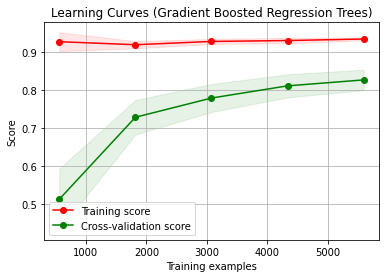

In [36]:
# graficamos con los mejores parámetros
title = "Learning Curves (Gradient Boosted Regression Trees)"
estimator = GradientBoostingRegressor(n_estimators=best_est.n_estimators, max_depth=best_est.max_depth, learning_rate=best_est.learning_rate, 
                                      min_samples_leaf=best_est.min_samples_leaf, max_features=best_est.max_features)
plot_learning_curve(estimator, title, X_train, y_train, cv=cv, n_jobs=n_jobs)
plt.show()

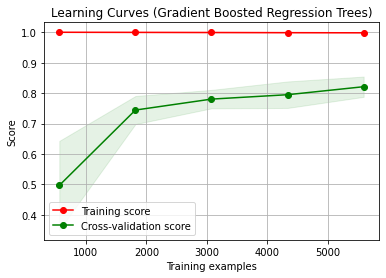

In [ ]:
# aumentamos la cantidad de estimadores a 1000 y lo graficamos, vemos que hay sobre ajuste
title = "Learning Curves (Gradient Boosted Regression Trees)"
estimator = GradientBoostingRegressor(n_estimators=1000, max_depth=best_est.max_depth, learning_rate=best_est.learning_rate, min_samples_leaf=best_est.min_samples_leaf, 
                                      max_features=best_est.max_features)
plot_learning_curve(estimator, title, X_train, y_train, cv=cv, n_jobs=n_jobs)
plt.show()

In [38]:
# estos son los resultados del coeficiente de determinacion R2 para el seet de entrenamiento y de prueba
estimator = best_est
#Re-fitting to the train set
estimator.fit(X_train, y_train)

print ("Train R-squared: %.2f" %estimator.score(X_train, y_train))
print ("Test R-squared: %.2f" %estimator.score(X_test, y_test))

Train R-squared: 0.94
Test R-squared: 0.74


REDES NEURONALES

In [23]:
pip install optuna

     |████████████████████████████████| 235kB 4.6MB/s 
     |████████████████████████████████| 1.1MB 13.4MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 81kB 9.9MB/s 
     |████████████████████████████████| 81kB 10.9MB/s 
     |████████████████████████████████| 133kB 24.9MB/s 
     |████████████████████████████████| 51kB 7.6MB/s 
     |████████████████████████████████| 112kB 26.1MB/s 
  Created wheel for alembic: filename=alembic-1.4.2-cp36-none-any.whl size=159540 sha256=7a55892a6080658e4de8809a7b97a238fd77a8d8fd1879a26dce35e637cfe7d2
  Stored in directory: /root/.cache/pip/wheels/1f/04/83/76023f7a4c14688c0b5c2682a96392cfdd3ee4449eaaa287ef
Successfully built alembic
  Created wheel for optuna: filename=optuna-2.0.0-cp36-none-any.whl size=312967 sha256=c802c8ec8b9e29e0b7ef5e1e562f562e2be5e422681d5cd21e4ab3dbd1f843d3
  Stored in directory: /root/.cache/pip/wheels/b

In [20]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers

print('Tensorflow Version : ',tf.__version__)

def build_model(input_dim,learning_rate=0.01):
    model = keras.Sequential([
        layers.Dense(80,activation='relu', input_shape=[input_dim]),
        layers.Dense(40,activation='relu'),
        layers.Dense(1,activation='linear')
      ])
    optimizer = tf.keras.optimizers.Adam(learning_rate)
    model.compile(loss='mse',optimizer=optimizer,metrics=['mae', 'mse'])
    return model

Tensorflow Version :  2.3.0


In [21]:
model = build_model(X.shape[1])

print("[INFO] training model...")
history=model.fit(x=X_train, y=y_train, validation_split=0.2,epochs=100,shuffle=True, batch_size=32,verbose=0)
print("[DONE] training model...")
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

[INFO] training model...
[DONE] training model...


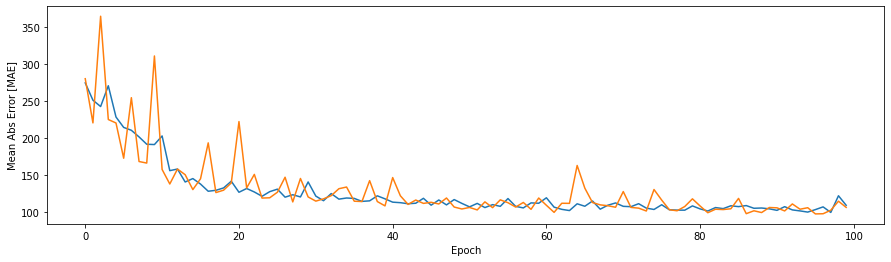

In [45]:
plt.figure(figsize=(15,4))
plt.xlabel('Epoch')
plt.ylabel('Mean Abs Error [MAE]')
plt.plot(hist['epoch'], hist['mae'],label='Train Error')
plt.plot(hist['epoch'], hist['val_mae'],label = 'Val Error')

r^2 on test data : 0.702654


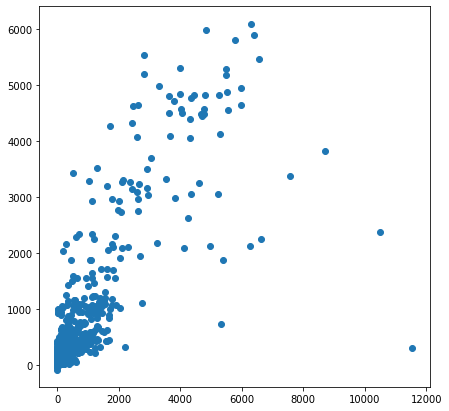

In [46]:
from sklearn.metrics import r2_score

y_hat=model.predict(X_test)
r2 = r2_score(y_test, y_hat.reshape(-1))
print("r^2 on test data : %f" % r2)
plt.figure(figsize=(7,7))
plt.scatter(y_test,y_hat.reshape(-1))

In [47]:
def build_regularized_model(input_dim,learning_rate=0.1,l1=1e-5,l2=1e-4):
    model = keras.Sequential([
        layers.Dense(80,activation='relu', input_shape=[input_dim]),
        layers.Dense(40,activation='relu',kernel_regularizer=regularizers.l1_l2(l1=l1, l2=l2),),
        layers.Dense(1,activation='linear')
      ])
    optimizer = tf.keras.optimizers.Adam(learning_rate)
    model.compile(loss='mse',optimizer=optimizer,metrics=['mae', 'mse'])
    return model

In [48]:
model = build_regularized_model(X.shape[1],l2=1e-1,l1=1e-2)
print("[INFO] training regularized model...")
history=model.fit(x=X_train, y=y_train, validation_split=0.2,epochs=100, batch_size=32,verbose=0)
print("[DONE] training regularized model...")
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

[INFO] training regularized model...
[DONE] training regularized model...


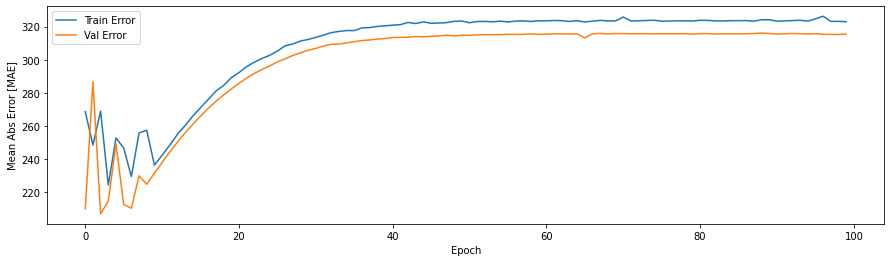

In [49]:
plt.figure(figsize=(15,4))
plt.xlabel('Epoch')
plt.ylabel('Mean Abs Error [MAE]')
plt.plot(hist['epoch'], hist['mae'],label='Train Error')
plt.plot(hist['epoch'], hist['val_mae'],label = 'Val Error')
plt.legend()

In [33]:
y_hat=model.predict(X_test)
r2 = r2_score(y_test, y_hat.reshape(-1))
print("r^2 on test data : %f" % r2)
plt.figure(figsize=(7,7))
plt.scatter(y_test,y_hat.reshape(-1))

NameError: ignored

In [24]:
from keras.backend import clear_session
from keras.models import Sequential
from keras.optimizers import RMSprop
import optuna

def objective(trial):
    # Clear clutter from previous Keras session graphs.
    clear_session()
    l1=trial.suggest_float("l1", 1e-5, 1e-1, log=True)
    l2=trial.suggest_float("l2", 1e-4, 1e-1, log=True)
    num_input = trial.suggest_int("n_input", 4, 128, log=True)
    num_hidden = trial.suggest_int("n_hidden", 4, 128, log=True)
    model = Sequential()
    input_dim=X_train.shape[1]
    model.add(layers.Dense(num_input,activation='relu',input_shape=[input_dim]))
    model.add(layers.Dense(num_hidden,activation='relu',kernel_regularizer=regularizers.l1_l2(l1=l1, l2=l2)))
    model.add(layers.Dense(1,activation='linear'))
    # We compile our model with a sampled learning rate.
    lr = trial.suggest_float("lr", 1e-4, 1e-1, log=True)
    model.compile(
        loss="mse", optimizer=RMSprop(lr=lr), metrics=['mae', 'mse']
    )
    model.fit(
        X_train,
        y_train,
        validation_split=0.2,
        epochs=20,
        shuffle=True,
        batch_size=32,
        verbose=False,
        use_multiprocessing=True,
    )
    # Evaluate the model accuracy on the validation set.
    score = model.evaluate(X_test, y_test, verbose=0)
    return score[1]

In [25]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, timeout=600)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

[I 2020-09-03 01:20:18,932] Trial 0 finished with value: 134.31182861328125 and parameters: {'l1': 0.01221786985651839, 'l2': 0.01778910035719611, 'n_input': 69, 'n_hidden': 8, 'lr': 0.05653805642422246}. Best is trial 0 with value: 134.31182861328125.
[I 2020-09-03 01:20:28,004] Trial 1 finished with value: 153.82833862304688 and parameters: {'l1': 0.00135939061389185, 'l2': 0.0006757743387571567, 'n_input': 6, 'n_hidden': 32, 'lr': 0.006286644070431767}. Best is trial 0 with value: 134.31182861328125.
[I 2020-09-03 01:20:37,171] Trial 2 finished with value: 207.41407775878906 and parameters: {'l1': 2.4158444161631548e-05, 'l2': 0.00027401932147032315, 'n_input': 5, 'n_hidden': 60, 'lr': 0.02468391196658741}. Best is trial 0 with value: 134.31182861328125.
[I 2020-09-03 01:20:46,240] Trial 3 finished with value: 289.963134765625 and parameters: {'l1': 3.244472449819603e-05, 'l2': 0.00010138613676392392, 'n_input': 17, 'n_hidden': 5, 'lr': 0.0001426611853600058}. Best is trial 0 with v

Number of finished trials: 66
Best trial:
  Value: 120.42350006103516


In [26]:
optuna.visualization.plot_contour(study, params=['l1', 'l2'])

In [27]:
optuna.visualization.plot_contour(study, params=['n_input', 'n_hidden'])

In [28]:
for key, value in trial.params.items():
  print("    {}: {}".format(key, value))

    l1: 0.003867337982044769
    l2: 0.006644441275122553
    n_input: 23
    n_hidden: 14
    lr: 0.03702311206220595


In [30]:
def build_auto_model(params):
  clear_session()
  model = Sequential()
  input_dim=X_train.shape[1]
  model.add(layers.Dense(params['n_input'],activation='relu',input_shape=[input_dim]))
  model.add(layers.Dense(params['n_hidden'],activation='relu',
                         kernel_regularizer=regularizers.l1_l2(l1=params['l1'], l2=params['l2'])))
  model.add(layers.Dense(1,activation='linear'))
  lr = params['lr']
  model.compile(loss="mse", optimizer=RMSprop(lr=lr), metrics=['mae', 'mse'])
  return model

model=build_auto_model(study.best_params)
print("[INFO] training auto model...")
history=model.fit(x=X_train, y=y_train, validation_data=(X_test, y_test),
                  use_multiprocessing=True,epochs=200, batch_size=32,verbose=0)
print("[DONE] training auto model...")
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

[INFO] training auto model...
[DONE] training auto model...


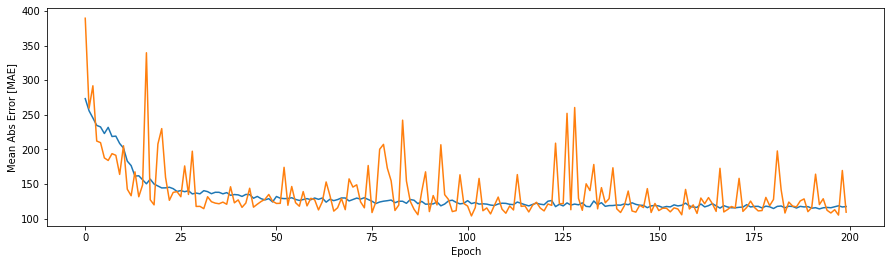

In [31]:
plt.figure(figsize=(15,4))
plt.xlabel('Epoch')
plt.ylabel('Mean Abs Error [MAE]')
plt.plot(hist['epoch'], hist['mae'],label='Train Error')
plt.plot(hist['epoch'], hist['val_mae'],label = 'Val Error')

r^2 on test data : 0.670684


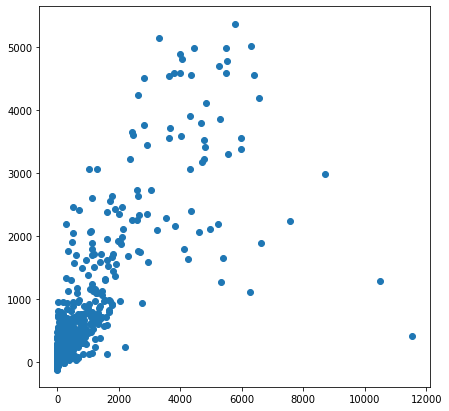

In [36]:
from sklearn.metrics import r2_score
y_hat=model.predict(X_test)

r2 = r2_score(y_test, y_hat.reshape(-1))
print("r^2 on test data : %f" % r2)

plt.figure(figsize=(7,7))
plt.scatter(y_test,y_hat.reshape(-1))